In [1]:
import numpy as np
import pickle
from sklearn.linear_model import RidgeClassifierCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, classification_report

In [2]:
import sys
sys.path.append('../../../')

from holsteinlib.evaluation_v2 import evaluate_model

In [3]:
def find_duplicates(arr1, arr2):
    set_arr2 = set(arr2)
    
    for i in arr1:
        if i in set_arr2:
            return True
    
    return False

In [4]:
def return_combined_indexes(calf_ids, calf_data_indexes):
    
    indexes = []
    
    for calf in calf_ids:
        sub_indexes = calf_data_indexes[calf]
        
        indexes.extend(sub_indexes)
    
    return indexes

In [5]:
class_labels = sorted(['drinking_milk', 'grooming', 'lying', 'other', 'running', 'walking'])

In [6]:
data_split_info_path = '../../../Datasets/SixBehaviourClassification/six_label_calf_split_info.pkl'
calf_data_index_info_path = '../../../Datasets/SixBehaviourClassification/ROCKET/calf_data_indexes_in_X_train.pickle'

In [7]:
# Loading ROCKET feature data
X_train_features = np.load('../../../Datasets/SixBehaviourClassification/ROCKET/X_train_features.npy')
X_test_features = np.load('../../../Datasets/SixBehaviourClassification/ROCKET/X_test_features.npy')

y_train = np.load('../../../Datasets/SixBehaviourClassification/ROCKET/y_train.npy')
y_test = np.load('../../../Datasets/SixBehaviourClassification/ROCKET/y_test.npy')

In [8]:
with open(data_split_info_path, 'rb') as handle:
    data_split_info = pickle.load(handle)

In [9]:
# Loading the validation calf data indexes in X_train (which also correspond 
# to the positio on X_train_features)

with open(calf_data_index_info_path, 'rb') as handle:
    calf_data_indexes = pickle.load(handle)

# GridSearch

In [ ]:
all_calf_ids = data_split_info['all_calves']
test_calf_ids = data_split_info['test_calves']
validation_sets = data_split_info['valid_calf_id_sets']

In [ ]:
folds = []
for valid_set in validation_sets:
    train_calves = [calf for calf in all_calf_ids if calf not in test_calf_ids and calf not in valid_set]
    
    # ensuring the generalization for the second time
    test_in_train = find_duplicates(test_calf_ids, train_calves)
    valid_in_train = find_duplicates(valid_set, train_calves)
    
    if not test_in_train and not valid_in_train:
        folds.append((return_combined_indexes(train_calves, calf_data_indexes), 
                     return_combined_indexes(valid_set, calf_data_indexes)))
    else:
        print('Error: Duplicate Entries found in the splits')

In [ ]:
print('Number of folds: ', len(folds))

In [ ]:
param_distributions = {
    'alphas': np.linspace(0.001, 1000, num=100),
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False],
}

# Initialize the RidgeClassifierCV
ridge_cv = RidgeClassifierCV()

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=ridge_cv, param_distributions=param_distributions, 
                                   n_iter=50, cv=folds, scoring='balanced_accuracy', random_state=42,
                                  verbose=2)


random_search.fit(X_train_features, y_train)

In [ ]:
# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation balanced accuracy: ", random_search.best_score_)

In [ ]:
# Best parameters found:  {'fit_intercept': False, 'class_weight': 'balanced', 'alphas': 131.31400000000002}
# Best cross-validation balanced accuracy:  0.7825888082391979

# Testing

In [10]:
# ridge_clf = RidgeClassifierCV(**random_search.best_params_)
ridge_clf = RidgeClassifierCV(fit_intercept= False, class_weight= 'balanced', alphas= 131.31400000000002)

ridge_clf.fit(X_train_features, y_train)

y_pre = ridge_clf.predict(X_test_features)

print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pre))

Balanced Accuracy:  0.7740254005552175


In [12]:
import joblib
joblib.dump(ridge_clf, '6_bhav_classi_Ridge_ROCKET_model.pkl')

['6_bhav_classi_Ridge_ROCKET_model.pkl']

In [11]:
class_wise_metrics, overall_report, additional_metrics, cm = evaluate_model(y_test, y_pre, class_labels)

all_results = {
    'class_wise_metrics' : class_wise_metrics,
    'overall_report' : overall_report,
    'additional_metrics' : additional_metrics,
    'confusion_matirx': cm
}

with open('Results/Test Results/test_results.pickle', 'wb') as handle:
    pickle.dump(all_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
print(overall_report)

               precision    recall  f1-score   support

drinking_milk       0.54      0.82      0.65      2072
     grooming       0.38      0.65      0.48       956
        lying       0.94      0.88      0.91      9762
        other       0.77      0.62      0.69      8985
      running       0.90      0.96      0.93       493
      walking       0.27      0.71      0.39       378

     accuracy                           0.76     22646
    macro avg       0.63      0.77      0.67     22646
 weighted avg       0.80      0.76      0.77     22646



In [13]:
additional_metrics

{'model_accuracy': 0.7603550295857988,
 'balanced_accuracy': 0.7740254005552175,
 'macro_precision': 0.6329889791719078,
 'macro_recall': 0.7740254005552175,
 'macro_f1-score': 0.6740731526217351}

# Extra-Feature Importance

## RandomForest FI

In [17]:
rf = RandomForestClassifier(n_estimators = 200, class_weight='balanced', criterion='gini', max_depth=10,
                           max_features='log2', min_samples_split=5)
rf.fit(X_train_features, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='log2', min_samples_split=5,
                       n_estimators=200)

In [19]:
importances = rf.feature_importances_
feature_names = [f"Feature {i}" for i in range(np.array(X_train_features).shape[1])]

In [21]:
import pandas as pd
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

In [22]:
results = {}
for i in feat_count:
    top_n = i  # You can change this to select more features
    top_features = feature_importances['Feature'][:top_n].values
    top_indices = feature_importances.index[:top_n].values
    
    X_train_top = np.array(X_train_features)[:, top_indices]
    X_test_top = np.array(X_test_features)[:, top_indices]
    
    ridge_clf = RidgeClassifierCV(fit_intercept= False, class_weight= 'balanced', alphas= 131.31400000000002)

    ridge_clf.fit(X_train_top, y_train)

    y_pre = ridge_clf.predict(X_test_top)
    
    ba = balanced_accuracy_score(y_test, y_pre)
    
    results[i] = ba
    
    print(f'{i} = Test Balanced Accuracy: {ba}')

5 = Test Balanced Accuracy: 0.5184810315391212
10 = Test Balanced Accuracy: 0.5405830236150275
15 = Test Balanced Accuracy: 0.5727671194924968
20 = Test Balanced Accuracy: 0.5874698284898257
30 = Test Balanced Accuracy: 0.6386256440963414
40 = Test Balanced Accuracy: 0.6482232177156425
50 = Test Balanced Accuracy: 0.6492644625336924
60 = Test Balanced Accuracy: 0.6649720914413946
70 = Test Balanced Accuracy: 0.6648813885018311
80 = Test Balanced Accuracy: 0.6672387083136463
90 = Test Balanced Accuracy: 0.6748484037804142
100 = Test Balanced Accuracy: 0.6766111982613533
200 = Test Balanced Accuracy: 0.7095667370303426
300 = Test Balanced Accuracy: 0.718910352709814
400 = Test Balanced Accuracy: 0.7381931257990755
500 = Test Balanced Accuracy: 0.7455029823167697
600 = Test Balanced Accuracy: 0.7481264360950665
700 = Test Balanced Accuracy: 0.753380448856697
800 = Test Balanced Accuracy: 0.7585770998561215
900 = Test Balanced Accuracy: 0.7593365929139521
1000 = Test Balanced Accuracy: 0.7

In [23]:
# sorted_dict = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
max_key = max(results, key=lambda k: results[k])
print(max_key)

7400


In [24]:
results[7400]

0.7767180781140955

In [14]:
feat_count = []

feat_count.extend([5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90])
feat_count.extend(np.arange(100, 10000, 100))

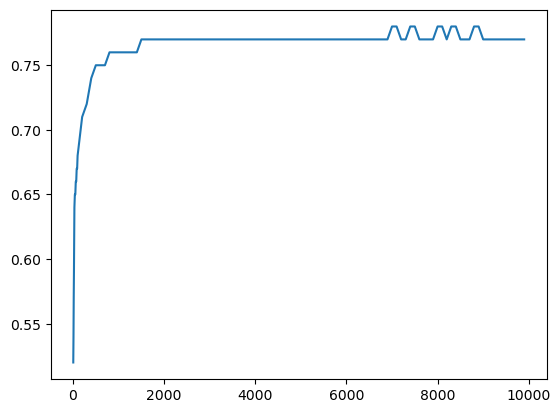

In [25]:
import matplotlib.pyplot as plt

plt.plot(results.keys(), [round(x, 2) for x in results.values()])

In [26]:
for fc, fi in results.items():
    if round(fi, 2) >= 0.78:
        print(fc)

7000
7100
7400
7500
8000
8100
8300
8400
8800
8900


## Mutual Importance

In [27]:
from sklearn.feature_selection import mutual_info_classif

In [28]:
mi_scores = mutual_info_classif(X_train_features, y_train)

feature_names = [f"Feature {i}" for i in range(X_train_features.shape[1])]
mi_importances = pd.DataFrame({'Feature': feature_names, 'Mutual Information': mi_scores})
mi_importances = mi_importances.sort_values(by='Mutual Information', ascending=False)

In [29]:
mi_results = {}
for i in feat_count:
    top_n = i  # You can change this to select more features
    top_features = mi_importances['Feature'][:top_n].values
    top_indices = mi_importances.index[:top_n].values
    
    X_train_top = np.array(X_train_features)[:, top_indices]
    X_test_top = np.array(X_test_features)[:, top_indices]
    
    ridge_clf = RidgeClassifierCV(fit_intercept= False, class_weight= 'balanced', alphas= 131.31400000000002)

    ridge_clf.fit(X_train_top, y_train)

    y_pre = ridge_clf.predict(X_test_top)
    
    ba = balanced_accuracy_score(y_test, y_pre)
    
    mi_results[i] = ba
    
    print(f'{i} = Test Balanced Accuracy: {ba}')

5 = Test Balanced Accuracy: 0.23894423558549882
10 = Test Balanced Accuracy: 0.3980868377568889
15 = Test Balanced Accuracy: 0.43582211285772493
20 = Test Balanced Accuracy: 0.4565656592273919
30 = Test Balanced Accuracy: 0.47438328711597544
40 = Test Balanced Accuracy: 0.5210785996523287
50 = Test Balanced Accuracy: 0.5361181311602744
60 = Test Balanced Accuracy: 0.5502114786311798
70 = Test Balanced Accuracy: 0.5580628671736688
80 = Test Balanced Accuracy: 0.5684616321497172
90 = Test Balanced Accuracy: 0.570178288819918
100 = Test Balanced Accuracy: 0.5695097657324752
200 = Test Balanced Accuracy: 0.6234023342811194
300 = Test Balanced Accuracy: 0.6458068172049902
400 = Test Balanced Accuracy: 0.6676427252058454
500 = Test Balanced Accuracy: 0.6755037208925646
600 = Test Balanced Accuracy: 0.6868157629531728
700 = Test Balanced Accuracy: 0.7013133837948661
800 = Test Balanced Accuracy: 0.7065909467442372
900 = Test Balanced Accuracy: 0.7135145351118779
1000 = Test Balanced Accuracy:

# Standardizing Features

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

In [22]:
# ridge_clf = RidgeClassifierCV(**random_search.best_params_)
ridge_clf = RidgeClassifierCV(fit_intercept= False, class_weight= 'balanced', alphas= 131.31400000000002)

ridge_clf.fit(X_train_scaled, y_train)

y_pre = ridge_clf.predict(X_test_scaled)

print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pre))

Balanced Accuracy:  0.7091024644277604


# Best Feature Selection

# RF

In [23]:
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='mean')
X_train_selected = selector.fit_transform(X_train_features, y_train)
X_test_selected = selector.transform(X_test_features)

In [24]:
# ridge_clf = RidgeClassifierCV(**random_search.best_params_)
ridge_clf = RidgeClassifierCV(fit_intercept= False, class_weight= 'balanced', alphas= 131.31400000000002)

ridge_clf.fit(X_train_selected, y_train)

y_pre = ridge_clf.predict(X_test_selected)

print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pre))

Balanced Accuracy:  0.7606338241532545


# Recursive Feature Elimination (RFE)

In [ ]:
ridge = RidgeClassifierCV(**random_search.best_params_)
selector = RFE(estimator=ridge, n_features_to_select=5000, step=1)  # Adjust n_features_to_select as needed

pipeline = Pipeline([
    ('rfe', selector),
    ('ridge', ridge)
])

pipeline.fit(X_train_features, y_train)
y_pred = pipeline.predict(X_test_features)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f"Balanced accuracy after RFE: {balanced_accuracy}")